In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nithin1729s","key":"79fbd95211d72689115cb6fb5f505606"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d watesoyan/omniglot


Dataset URL: https://www.kaggle.com/datasets/watesoyan/omniglot
License(s): copyright-authors
 96% 29.0M/30.1M [00:02<00:00, 21.4MB/s]
100% 30.1M/30.1M [00:02<00:00, 12.8MB/s]


In [5]:
!unzip omniglot.zip -d omniglot_data


Streaming output truncated to the last 5000 lines.
  inflating: omniglot_data/omniglot/images_evaluation/Mongolian/character16/1374_01.png  
  inflating: omniglot_data/omniglot/images_evaluation/Mongolian/character16/1374_02.png  
  inflating: omniglot_data/omniglot/images_evaluation/Mongolian/character16/1374_03.png  
  inflating: omniglot_data/omniglot/images_evaluation/Mongolian/character16/1374_04.png  
  inflating: omniglot_data/omniglot/images_evaluation/Mongolian/character16/1374_05.png  
  inflating: omniglot_data/omniglot/images_evaluation/Mongolian/character16/1374_06.png  
  inflating: omniglot_data/omniglot/images_evaluation/Mongolian/character16/1374_07.png  
  inflating: omniglot_data/omniglot/images_evaluation/Mongolian/character16/1374_08.png  
  inflating: omniglot_data/omniglot/images_evaluation/Mongolian/character16/1374_09.png  
  inflating: omniglot_data/omniglot/images_evaluation/Mongolian/character16/1374_10.png  
  inflating: omniglot_data/omniglot/images_evalua

In [6]:
import os

dataset_path = "omniglot_data"
print("Folders in Omniglot dataset:", os.listdir(dataset_path))

Folders in Omniglot dataset: ['images_background', 'images_evaluation', 'omniglot']


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Input, Flatten, Dense, Lambda
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
import numpy.random as rng


In [8]:
def loadimgs(path, n=0):
    """
    Loads images from a given Omniglot folder.

    Args:
        path (str): Directory path (e.g. images_background or images_evaluation).
        n (int): Starting label index.

    Returns:
        X: NumPy array of shape (num_categories, num_examples, width, height)
        y: Labels (not used in training the Siamese net, but kept for reference)
        lang_dict: Dictionary mapping alphabet names to (min_label, max_label)
    """
    X = []
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n

    # Iterate over each alphabet in the given path.
    for alphabet in os.listdir(path):
        print("Loading alphabet:", alphabet)
        lang_dict[alphabet] = [curr_y, None]
        alphabet_path = os.path.join(path, alphabet)
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images = []
            letter_path = os.path.join(alphabet_path, letter)
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            except ValueError as e:
                print("Error stacking images for category:", curr_y, e)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1

    y = np.vstack(y)
    X = np.stack(X)
    return X, y, lang_dict

In [9]:
# Set paths (adjust these paths as needed for your environment)
train_folder = '/content/omniglot_data/images_background'
val_folder = '/content/omniglot_data/images_evaluation'

In [10]:
X,y,c = loadimgs(train_folder)

Loading alphabet: Grantha
Loading alphabet: Alphabet_of_the_Magi
Loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
Loading alphabet: Mkhedruli_(Georgian)
Loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
Loading alphabet: Syriac_(Estrangelo)
Loading alphabet: Asomtavruli_(Georgian)
Loading alphabet: Korean
Loading alphabet: Braille
Loading alphabet: Burmese_(Myanmar)
Loading alphabet: Japanese_(katakana)
Loading alphabet: Armenian
Loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
Loading alphabet: Malay_(Jawi_-_Arabic)
Loading alphabet: Latin
Loading alphabet: Bengali
Loading alphabet: Tagalog
Loading alphabet: Balinese
Loading alphabet: Greek
Loading alphabet: Japanese_(hiragana)
Loading alphabet: Tifinagh
Loading alphabet: Hebrew
Loading alphabet: Futurama
Loading alphabet: Arcadian
Loading alphabet: Early_Aramaic
Loading alphabet: N_Ko
Loading alphabet: Sanskrit
Loading alphabet: Gujarati
Loading alphabet: Cyrillic
Loading alphabet: Anglo-Saxon_Futhorc


In [11]:
Xval,yval,cval=loadimgs(val_folder)

Loading alphabet: Oriya
Loading alphabet: Ge_ez
Loading alphabet: ULOG
Loading alphabet: Atlantean
Loading alphabet: Old_Church_Slavonic_(Cyrillic)
Loading alphabet: Sylheti
Loading alphabet: Syriac_(Serto)
Loading alphabet: Angelic
Loading alphabet: Tengwar
Loading alphabet: Kannada
Loading alphabet: Aurek-Besh
Loading alphabet: Glagolitic
Loading alphabet: Malayalam
Loading alphabet: Tibetan
Loading alphabet: Keble
Loading alphabet: Manipuri
Loading alphabet: Atemayar_Qelisayer
Loading alphabet: Gurmukhi
Loading alphabet: Mongolian
Loading alphabet: Avesta


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Input, Flatten, Dense, Lambda, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import numpy as np

# Corrected Initializers using TensorFlow
def initialize_bias(shape, dtype=None):
    return tf.keras.initializers.RandomNormal(mean=0.5, stddev=1e-2)(shape)

def initialize_weights(shape, dtype=None):
    return tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2)(shape)

def get_siamese_model(input_shape):
    # Define the tensors for the two input images
    left_input = Input(shape=input_shape)
    right_input = Input(shape=input_shape)

    # Shared CNN model
    x = Conv2D(64, (10, 10), activation='relu', kernel_initializer=initialize_weights,
               kernel_regularizer=l2(2e-4))(left_input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (7, 7), activation='relu', kernel_initializer=initialize_weights,
               bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (4, 4), activation='relu', kernel_initializer=initialize_weights,
               bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, (4, 4), activation='relu', kernel_initializer=initialize_weights,
               bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid', kernel_regularizer=l2(1e-3),
              kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(x)

    # Shared model definition
    shared_model = Model(left_input, x)

    # Generate the encodings (feature vectors) for the two images
    encoded_l = shared_model(left_input)
    encoded_r = shared_model(right_input)

    # Add a customized layer to compute the absolute difference between encodings
    L1_distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid activation for similarity score
    prediction = Dense(1, activation='sigmoid', bias_initializer=initialize_bias)(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

    return siamese_net

# Example Usage
input_shape = (105, 105, 1)
model = get_siamese_model(input_shape)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 105, 105, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 4096)           │     38,947,648 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 4096)           │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          4,097 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,951,745 (148.59 MB)

 Trainable params: 38,951,745 (148.59 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

In [14]:
train_classes=c.keys()

In [15]:
test_classes=cval.keys()

train_classes = list(c.keys())  # Defined from the train dataset 'c'
val_classes = list(cval.keys())
Xtrain=X

In [16]:
def get_batch(batch_size,s="train"):
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)

    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]

    # initialize vector for the targets
    targets=np.zeros((batch_size,))

    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)

        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes

        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)

    return pairs, targets

In [17]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [18]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets


In [19]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [20]:
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 4
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [22]:
import time
import os
from google.colab import files

print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
best = 0.0

n_iter = 20000
batch_size = 4

for i in range(1, n_iter+1):
    (inputs, targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % 5000 == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss))

        # Fix: Ensure filename ends with `.weights.h5`
        weights_path = f'/content/siamese_model_weights_{i}.weights.h5'

        model.save_weights(weights_path)
        print("Weights saved at:", weights_path)
        files.download(weights_path)


Starting training process!
-------------------------------------

 ------------- 

Time for 5000 iterations: 2.233296243349711 mins
Train Loss: 0.6183653473854065
Weights saved at: /content/siamese_model_weights_5000.weights.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 ------------- 

Time for 10000 iterations: 4.553975876172384 mins
Train Loss: 0.5441175699234009
Weights saved at: /content/siamese_model_weights_10000.weights.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 ------------- 

Time for 15000 iterations: 6.8514379103978476 mins
Train Loss: 0.4975329041481018
Weights saved at: /content/siamese_model_weights_15000.weights.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 ------------- 

Time for 20000 iterations: 9.085735976696014 mins
Train Loss: 0.4639854431152344
Weights saved at: /content/siamese_model_weights_20000.weights.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
model.load_weights('/content/siamese_model_weights_20000.weights.h5')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 105, 105, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 4096)           │     38,947,648 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 4096)           │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          4,097 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 116,855,237 (445.77 MB)

 Trainable params: 38,951,745 (148.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 77,903,492 (297.18 MB)

In [24]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [25]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0

    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [26]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [27]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("--------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━

<ipython-input-24-0e6416d38168>:6: RuntimeWarning: invalid value encountered in sqrt
  L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

In [28]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [29]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [31]:
def make_oneshot_task(N, s="val", language=None):
    if s == 'train':
        X = Xtrain
        mapping = c   # Use the dictionary mapping alphabet names to (min, max)
    else:
        X = Xval
        mapping = cval

    n_classes, n_examples, w, h = X.shape
    indices = rng.randint(0, n_examples, size=(N,))

    if language is not None:  # If a language is specified, use its range from the mapping
        low, high = mapping[language]  # This works because mapping is a dictionary
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low, high), size=(N,), replace=False)
    else:
        categories = rng.choice(range(n_classes), size=(N,), replace=False)

    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]] * N).reshape(N, w, h, 1)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, 1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]

    return pairs, targets


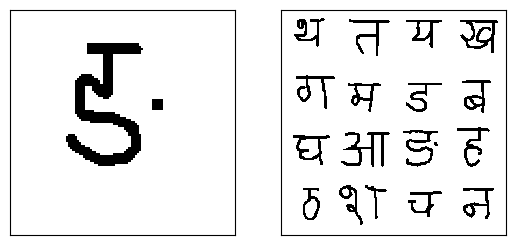

In [35]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
plot_oneshot_task(pairs)

In [36]:
predictions = model.predict(pairs)
print("Predictions:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predictions: [[9.8961557e-04]
 [2.3533661e-02]
 [9.2847012e-03]
 [2.8861619e-03]
 [3.9641713e-03]
 [4.4470495e-03]
 [6.3859332e-01]
 [2.6141235e-01]
 [2.1699559e-02]
 [1.8357563e-04]
 [7.9748732e-01]
 [6.9192523e-01]
 [9.9718589e-01]
 [1.5955163e-03]
 [1.9994853e-02]
 [1.3514232e-03]]


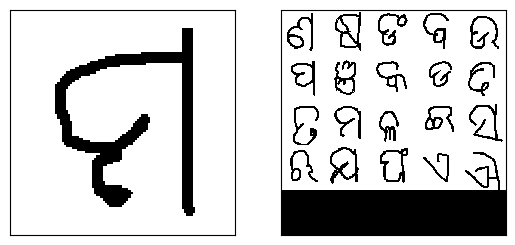

In [33]:
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plot_oneshot_task(inputs)

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_support_set_with_predictions(pairs, predictions):
    """
    Plots each image in the support set with its prediction score.
    Highlights the image with the highest score in red.
    """
    support_set = pairs[1]  # The support set images
    N, h, w, _ = support_set.shape
    n = int(np.ceil(np.sqrt(N)))  # Determine grid size

    predicted_index = np.argmax(predictions)  # Get index of best match

    plt.figure(figsize=(10, 10))
    for i in range(N):
        plt.subplot(n, n, i+1)
        plt.imshow(support_set[i].reshape(h, w), cmap='gray')
        plt.title(f"Score: {predictions[i][0]:.2f}", fontsize=10)
        # Highlight the predicted best match with a red border
        if i == predicted_index:
            ax = plt.gca()
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)
        plt.axis('off')
    plt.tight_layout()
    plt.show()




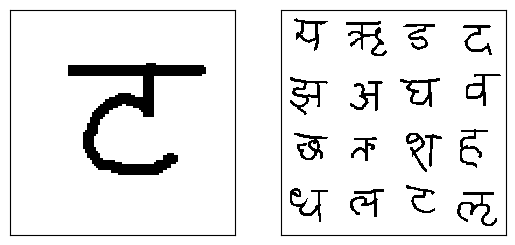

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


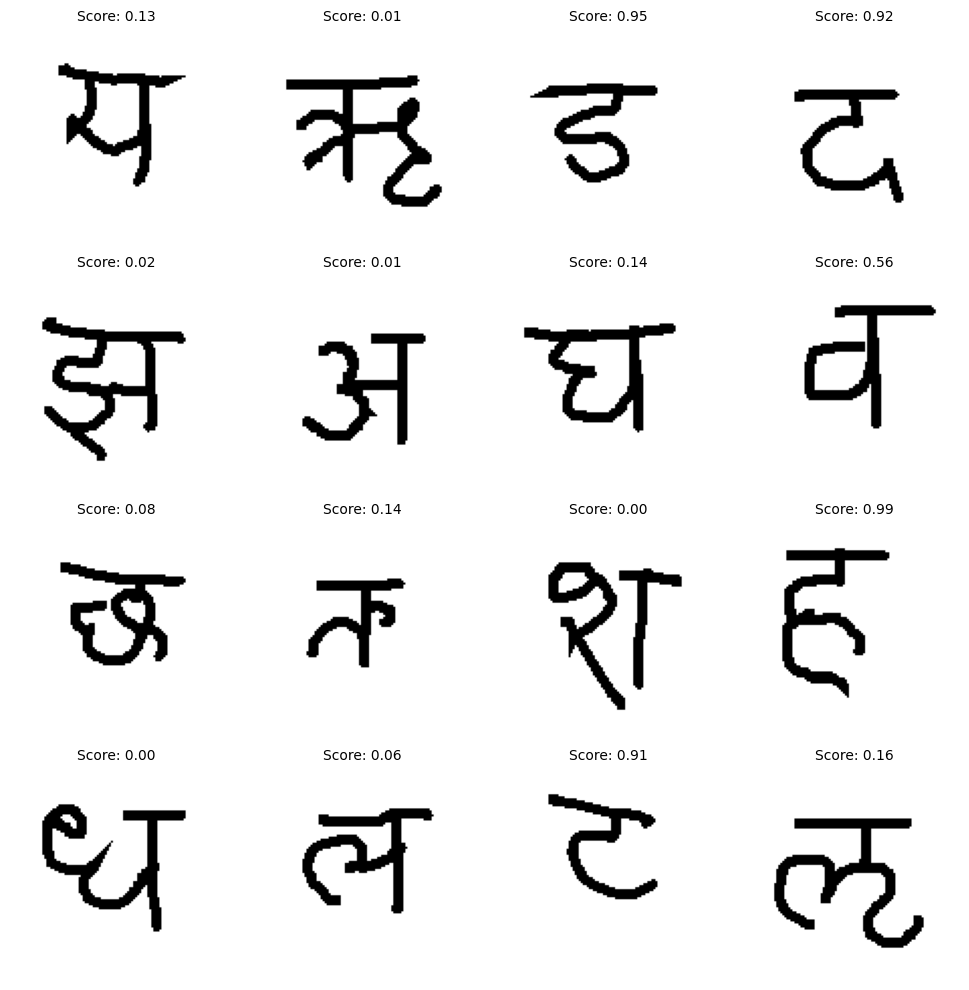

In [39]:
# Example usage:
pairs, targets = make_oneshot_task(16, "train", "Sanskrit")
plot_oneshot_task(pairs)  # Your existing visualization function
predictions = model.predict(pairs)
# Plot each support image with its prediction score and highlight the best match
plot_support_set_with_predictions(pairs, predictions)

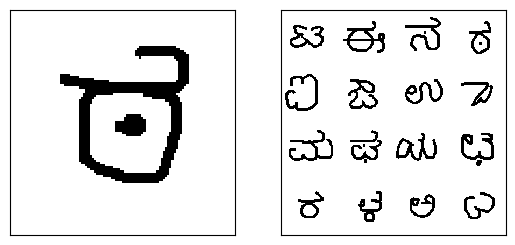

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


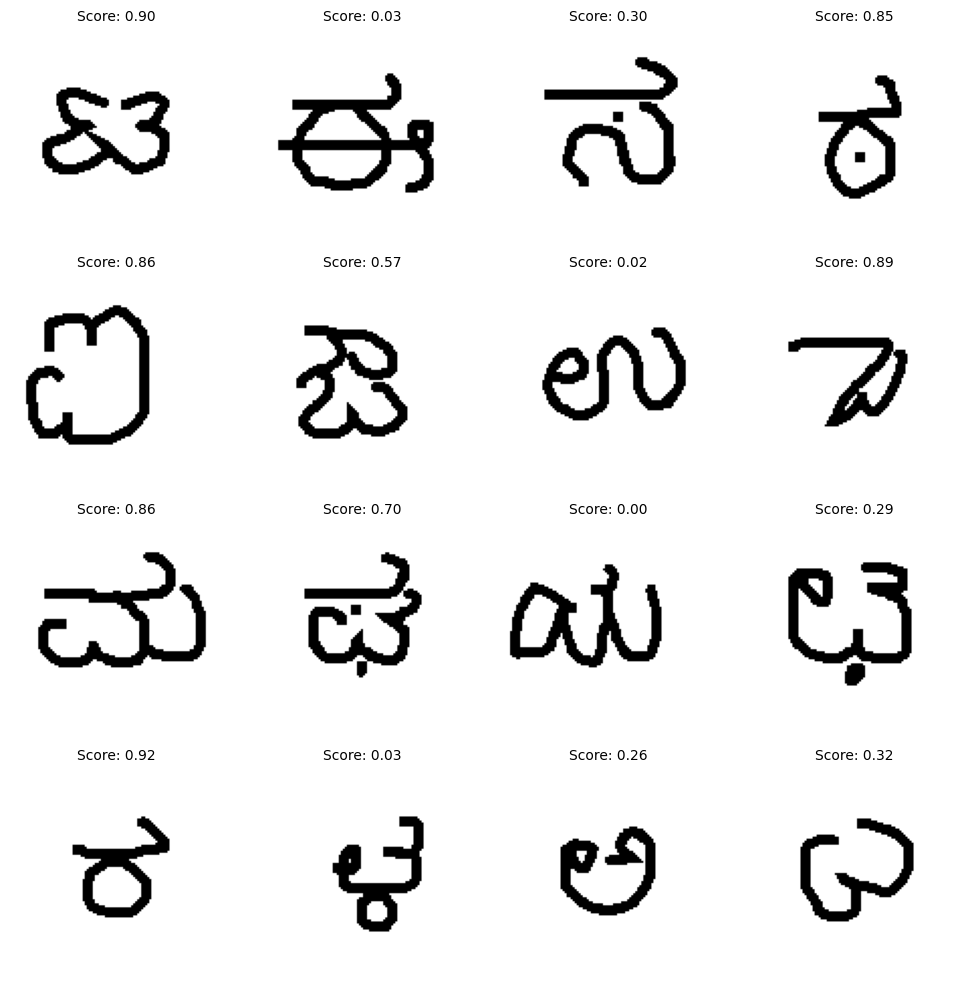

In [41]:
# Example usage:
pairs, targets = make_oneshot_task(16, "test", "Kannada")
plot_oneshot_task(pairs)  # Your existing visualization function
predictions = model.predict(pairs)
# Plot each support image with its prediction score and highlight the best match
plot_support_set_with_predictions(pairs, predictions)

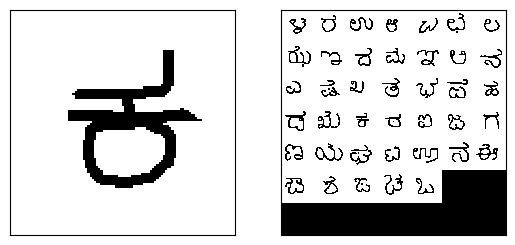

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 649ms/step


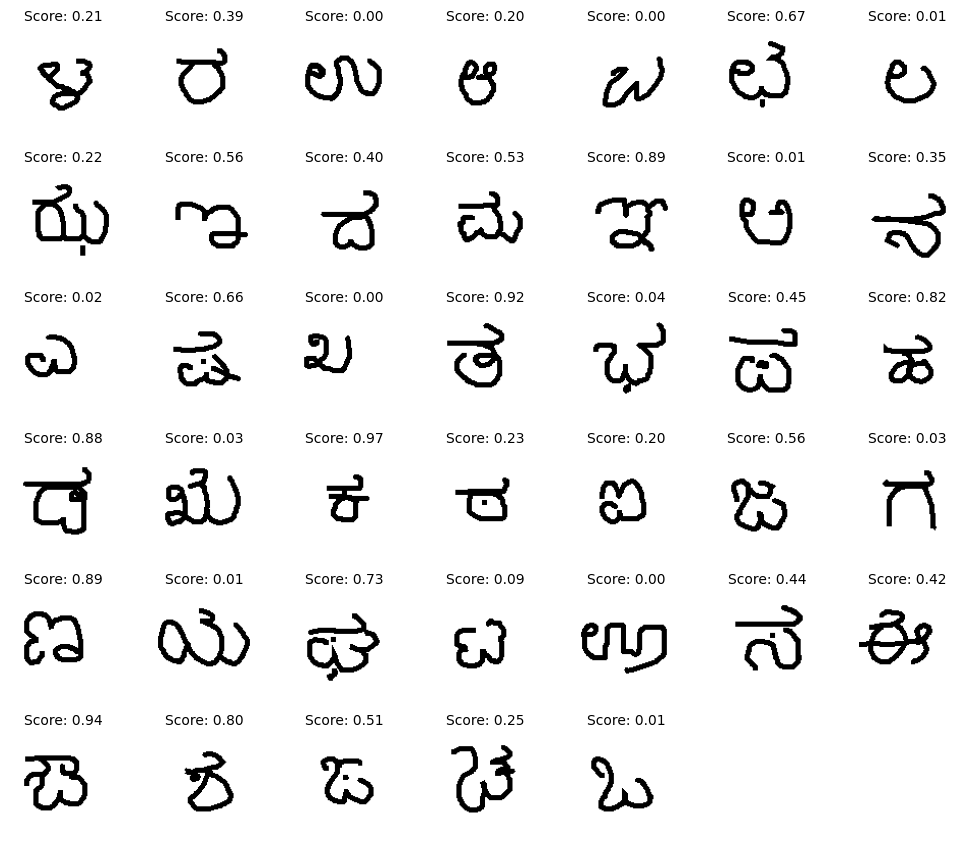

In [42]:
# Example usage:
pairs, targets = make_oneshot_task(40, "test", "Kannada")
plot_oneshot_task(pairs)  # Your existing visualization function
predictions = model.predict(pairs)
# Plot each support image with its prediction score and highlight the best match
plot_support_set_with_predictions(pairs, predictions)